This notebook builds a surrogate model for the macroeconomic impacts of improvements in biological aging.

To run this notebooks, use the `dynviz-dev` virtual environment, which can be build using the `environment.yml` file located in the same directory as this notebook.

# Imports

In [1]:
# imports
import numpy as np
import os
import pandas as pd
import scipy.interpolate as si
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split

## 1. Prep the data
The following data contains 1 predicted variable $y$ which is an $N\times 1$ vector and one matrix of 6 input variables $X$ which is an $N\times 6$ matrix, where $N=27,472$. 

In [3]:
# Set the current directory as the cur_dir path
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data')

# Read in the data
X = np.loadtxt(os.path.join(data_dir, 'X.txt'), delimiter=',')
y = np.loadtxt(os.path.join(data_dir, 'y.txt'), delimiter=',').reshape(-1, 1)
print(f"The shape of X is {X.shape}")
print(f"The shape of y is {y.shape}")

The shape of X is (27472, 6)
The shape of y is (27472, 1)


In [4]:
# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=True
)

Here is the linear N-dimensional interpolant that we fit to our sparse runs of 472 data points in this $(X,y)$ space. This interpolant `interpolant_avg_diff()` is an estimated `scipy.interpolate.LinearNDInterpolator` object. This would be useful, e.g., if you want to use the surrogate model to generate new data points for each epoch.

In [5]:
interpolant_avg_diff = pickle.load(
    open(
        os.path.join(data_dir, "interpolant_avg_diff.pkl"), "rb"
    )
)
# using
prediction = interpolant_avg_diff(X_test)
print("Predictions = ", prediction[:5])

/var/folders/d4/trj3dssd6s3g8kxvjmczz11w0000gn/T/ipykernel_75912/4103796048.py:1: DeprecationWarning: Please import `LinearNDInterpolator` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpnd` namespace is deprecated and will be removed in SciPy 2.0.0.
  interpolant_avg_diff = pickle.load(


Predictions =  [[2472.26461622]
 [1701.04342628]
 [ 682.2876416 ]
 [1760.64694548]
 [1204.88980962]]


# Set up the NN model

In [6]:
# set some hyperparameters
nodes_per_layer = 20 # multiplied by num inputs
activation_function = "relu"
num_epochs = 100
learning_rate = 0.001
# set up early stopping
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5000)

In [7]:
# Layer setting
num_input = X.shape[1]
num_hidden_layers = 7
num_hidden = np.zeros(num_hidden_layers)
# Start with more nodes per layer and decrease
for i in range(num_hidden_layers):
    num_hidden[i] = (nodes_per_layer - i * 2) * num_input
# num_hidden = nodes_per_layer * num_input
num_output = y.shape[1]
layers_dim = [num_input, num_hidden, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [6, array([120., 108.,  96.,  84.,  72.,  60.,  48.]), 1]


In [8]:
# Define the normalization function of the output
def normalize_output(data):
    data_max = np.max(data)
    data_min = np.min(data)
    return (data - data_min) / (data_max - data_min)

In [10]:
# Create a normalization layer for the inputs
norm_layer = tf.keras.layers.Normalization(input_shape=[num_input,], axis=-1)
# norm_layer = tf.keras.layers.Normalization(input_shape=[num_input,], axis=None)

# Initialize the weights
initializer = tf.keras.initializers.HeNormal(99)
# initializer = tf.keras.initializers.HeUniform()

# Adapt the layer to your training data
norm_layer.adapt(X_train)
nn = tf.keras.Sequential(
    [
        norm_layer,
        keras.layers.Dense(num_hidden[0], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[1], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[2], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[3], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[4], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[5], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[6], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_output, kernel_initializer=initializer),
    ]
)
print(nn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 6)                 13        
 tion)                                                           
                                                                 
 dense_8 (Dense)             (None, 120)               840       
                                                                 
 dense_9 (Dense)             (None, 108)               13068     
                                                                 
 dense_10 (Dense)            (None, 96)                10464     
                                                                 
 dense_11 (Dense)            (None, 84)                8148      
                                                                 
 dense_12 (Dense)            (None, 72)                6120      
                                                      

In [11]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
nn.compile(optimizer=optimizer, loss=loss_fn, metrics=['mean_squared_error'])

Train the model.

In [12]:
history = nn.fit(
    X_train, normalize_output(y_train),
    epochs=num_epochs,
    callbacks=[callback],
    # sample_weight=sample_weights,
    batch_size=32,
    validation_data=(X_test,  normalize_output(y_test)),
    validation_freq=5,   # Evaluate every 5 epochs
    verbose=1
)

Epoch 1/100
687/687 [==============================] - 1s 1ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2/100
687/687 [==============================] - 1s 1ms/step - loss: 4.1973e-04 - mean_squared_error: 4.1973e-04
Epoch 3/100
687/687 [==============================] - 1s 1ms/step - loss: 2.5104e-04 - mean_squared_error: 2.5104e-04
Epoch 4/100
687/687 [==============================] - 1s 1ms/step - loss: 2.1135e-04 - mean_squared_error: 2.1135e-04
Epoch 5/100
687/687 [==============================] - 1s 1ms/step - loss: 1.9093e-04 - mean_squared_error: 1.9093e-04 - val_loss: 2.1363e-04 - val_mean_squared_error: 2.1363e-04
Epoch 6/100
687/687 [==============================] - 1s 1ms/step - loss: 1.7413e-04 - mean_squared_error: 1.7413e-04
Epoch 7/100
687/687 [==============================] - 1s 1ms/step - loss: 1.6051e-04 - mean_squared_error: 1.6051e-04
Epoch 8/100
687/687 [==============================] - 1s 1ms/step - loss: 1.7333e-04 - mean_squared_error: 1.7333e

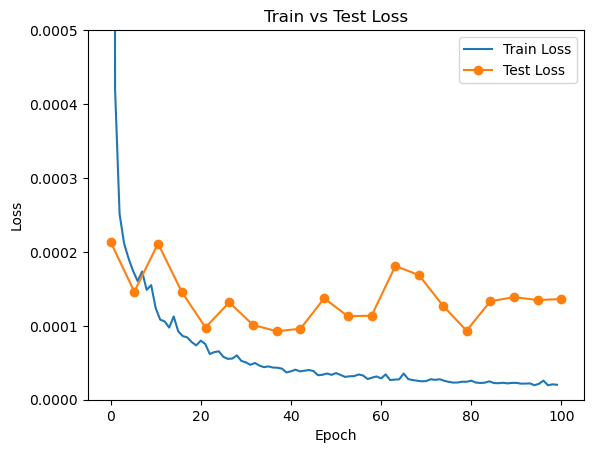

In [13]:
# Plot training and validation loss
plt.plot(np.arange(num_epochs), history.history['loss'], label='Train Loss')
plt.plot(
    np.linspace(0, num_epochs, num=int(np.ceil(num_epochs/5))),
    history.history['val_loss'], label='Test Loss', marker='o'
)
plt.ylim(0, 0.0005)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()

# Check the fit of the model

In [14]:
nn.evaluate(X,  normalize_output(y), verbose=2)

859/859 - 0s - loss: 1.2431e-04 - mean_squared_error: 1.2431e-04 - 315ms/epoch - 367us/step


[0.00012431027425918728, 0.00012431027425918728]

## Checking against the original data

In [15]:
output_variable = "avg_diff"
predictions_normed = nn.predict(X)
# Rescale the predictions
predictions = predictions_normed * (y.max() - y.min()) + y.min()
y_pred = predictions
y_diff = y - y_pred
print(
    f"The mean abs diff between y and y_pred is {np.absolute(y_diff).mean()}."
)
print(f"The max diff between y and y_pred is {y_diff.max()}.")
print(f"The min diff between y and y_pred is {y_diff.min()}.")

859/859 [==============================] - 0s 392us/step
The mean abs diff between y and y_pred is 43.452346028208204.
The max diff between y and y_pred is 296.6641874277152.
The min diff between y and y_pred is -193.34191910188383.


In [29]:
normalization_layer = nn.get_layer('normalization')
mean = normalization_layer.mean.numpy()
variance = normalization_layer.variance.numpy()
print("Mean: ", mean)
print("Std dev: ", variance**(1/2))

Mean:  [[54.73748     8.35946     8.381766    1.8990896   1.8962128   0.53320134]]
Std dev:  [[5.95917    4.787876   4.805051   1.4172095  1.4169149  0.39561728]]


# Check closeness to runs used in Silver Linings Book

There are a number of runs included in the Silver Linings book that we want to hit **extremely** closely. We can check how close the surrogate model is to these runs.

In [16]:
# Load model
X_book = X[-472:, :]
y_book = y[-472:, :]

# predict using the model
y_book_pred_norm = nn.predict(X_book)
y_book_pred = y_book_pred_norm * (y.max() - y.min()) + y.min()
y_book_diff = y_book - y_book_pred
print(
    f"The mean abs diff between y_book_pred and y_book " +
    f"is {np.absolute(y_book_diff).mean()}."
)
print(f"The max diff between y_book_pred and y_book is {y_book_diff.max()}.")
print(f"The min diff between y_book_pred and y_book is {y_book_diff.min()}.")


15/15 [==============================] - 0s 512us/step
The mean abs diff between y_book_pred and y_book is 39.115684254982874.
The max diff between y_book_pred and y_book is 38.33527331989353.
The min diff between y_book_pred and y_book is -130.4563545554597.
